In [1]:
import matplotlib.pylab as plt
import sys
import numpy as np
import pandas as pd

import itertools as it

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

%load_ext autoreload
%autoreload 2

In [2]:
data_bkg = np.load('shield_cands_muons.npz')
print(data_bkg.files)

['W', 'Pdg', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz']


In [3]:
w_bkg = data_bkg['W']
X_bkg = pd.DataFrame({'X': data_bkg['X'], 'Y': data_bkg['Y'],
                      'Px': data_bkg['Px'], 'Py': data_bkg['Py'], 'Pz': data_bkg['Pz']})

In [4]:
data_sig = np.load('HNL_100k_ecn3_geom_1_4_ch_muons.npz')
print(data_sig.files)

['W', 'Vx', 'Vy', 'Vz', 'Pdg', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz']


In [5]:
w_sig = data_sig['W']
X_sig = pd.DataFrame({'X': data_sig['X'], 'Y': data_sig['Y'],
                      'Px': data_sig['Px'], 'Py': data_sig['Py'], 'Pz': data_sig['Pz']})


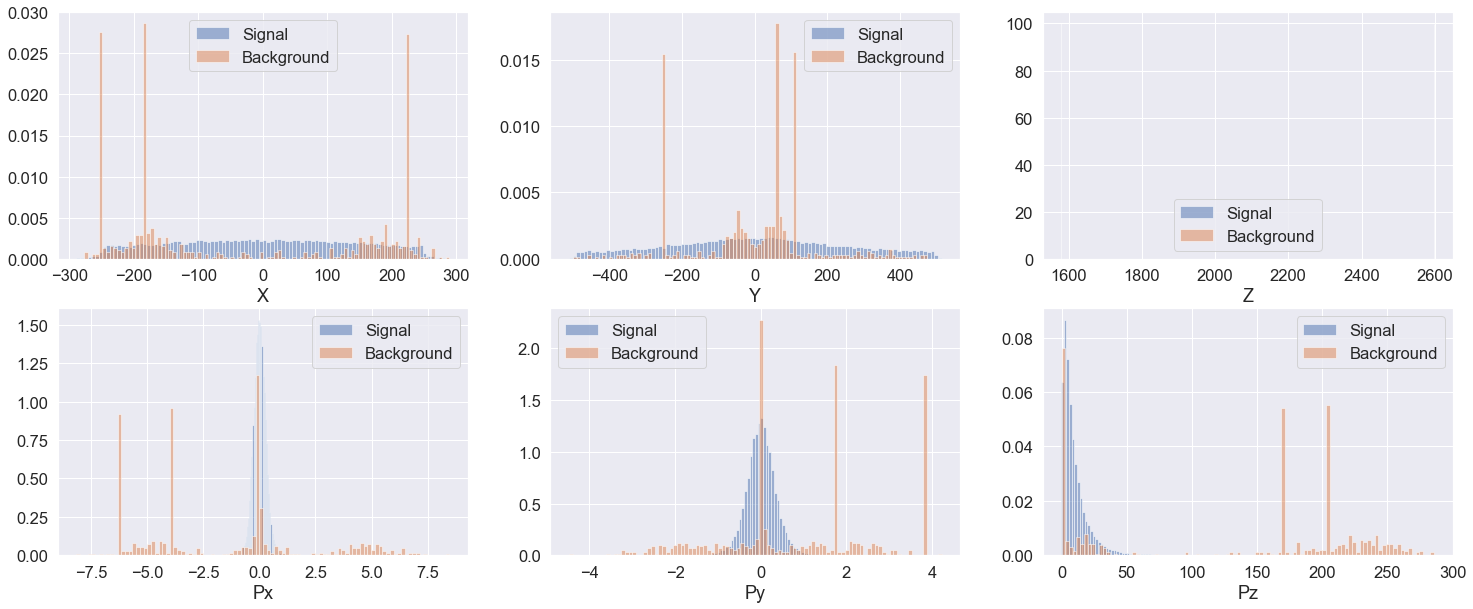

In [6]:
plt.figure(figsize=(25, 10))

for num, val in enumerate(['X', 'Y', 'Z', 'Px', 'Py', 'Pz']):

    plt.subplot(2, 3, num + 1)

    plt.hist(data_sig[val], weights=w_sig, label='Signal', density=True, bins=100, alpha=0.5)
    plt.hist(data_bkg[val], weights=w_bkg, label='Background', density=True, bins=100, alpha=0.5)
    
    plt.xlabel(val)
    plt.legend()
    
plt.show()

In [7]:
data = X_bkg.append(X_sig)
data['type'] = np.hstack((np.ones_like(w_bkg), np.zeros_like(w_sig)))

In [8]:
X = data.drop(['type'], axis=1)
y = data['type']

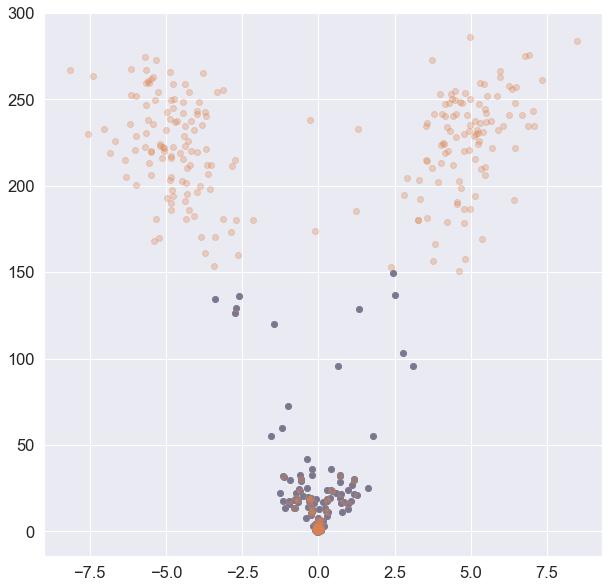

In [14]:
plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 1)
plt.scatter(X_bkg[X_bkg['Pz'] < 150]['Px'], X_bkg[X_bkg['Pz'] < 150]['Pz'], alpha=1)

plt.scatter(X_bkg[X_bkg['Pz'] < 15000]['Px'], X_bkg[X_bkg['Pz'] < 15000]['Pz'], alpha=0.3)

In [673]:
from sklearn.model_selection import train_test_split

* Определить оптимальный test_size

Будем максимизировать метрику recall, так как нам необходимо избавиться от всего мусора и оставить реальные события (так как в эксперименте статистика не важна и хватит даже одного события).

In [674]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

>## BaseLine

In [675]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score

In [676]:
def get_metrics(X, y, states=[0, 6, 7, 13, 42, 911], size=0.3):

    log_reg_rec = []
    knn_rec = []

    log_reg_prs = []
    knn_prs = []

    for state in states:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=size)
        
        log_reg = LogisticRegression().fit(X_train, y_train).predict(X_test)
        knn = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)

        log_reg_rec.append(recall_score(y_test, log_reg))
        knn_rec.append(recall_score(y_test, knn))

        log_reg_prs.append(precision_score(y_test, log_reg))
        knn_prs.append(precision_score(y_test, knn))

    return pd.DataFrame({'method': ['log_reg', 'knn'], 
              'recall': [np.mean(log_reg_rec), np.mean(knn_rec)],
              'precision': [np.mean(log_reg_prs), np.mean(knn_prs)]})

In [677]:
get_metrics(X, y)

,method,recall,precision
0,log_reg,0.587687,0.968921
1,knn,0.627948,1.000000


>## Feature-инжиниринг

In [ ]:
X['T'] = X['Px'] ** 2 + X['Py'] ** 2 + X['Pz'] ** 2

In [679]:
get_metrics(X, y)

,method,recall,precision
0,log_reg,0.596730,0.946925
1,knn,0.595353,0.946645


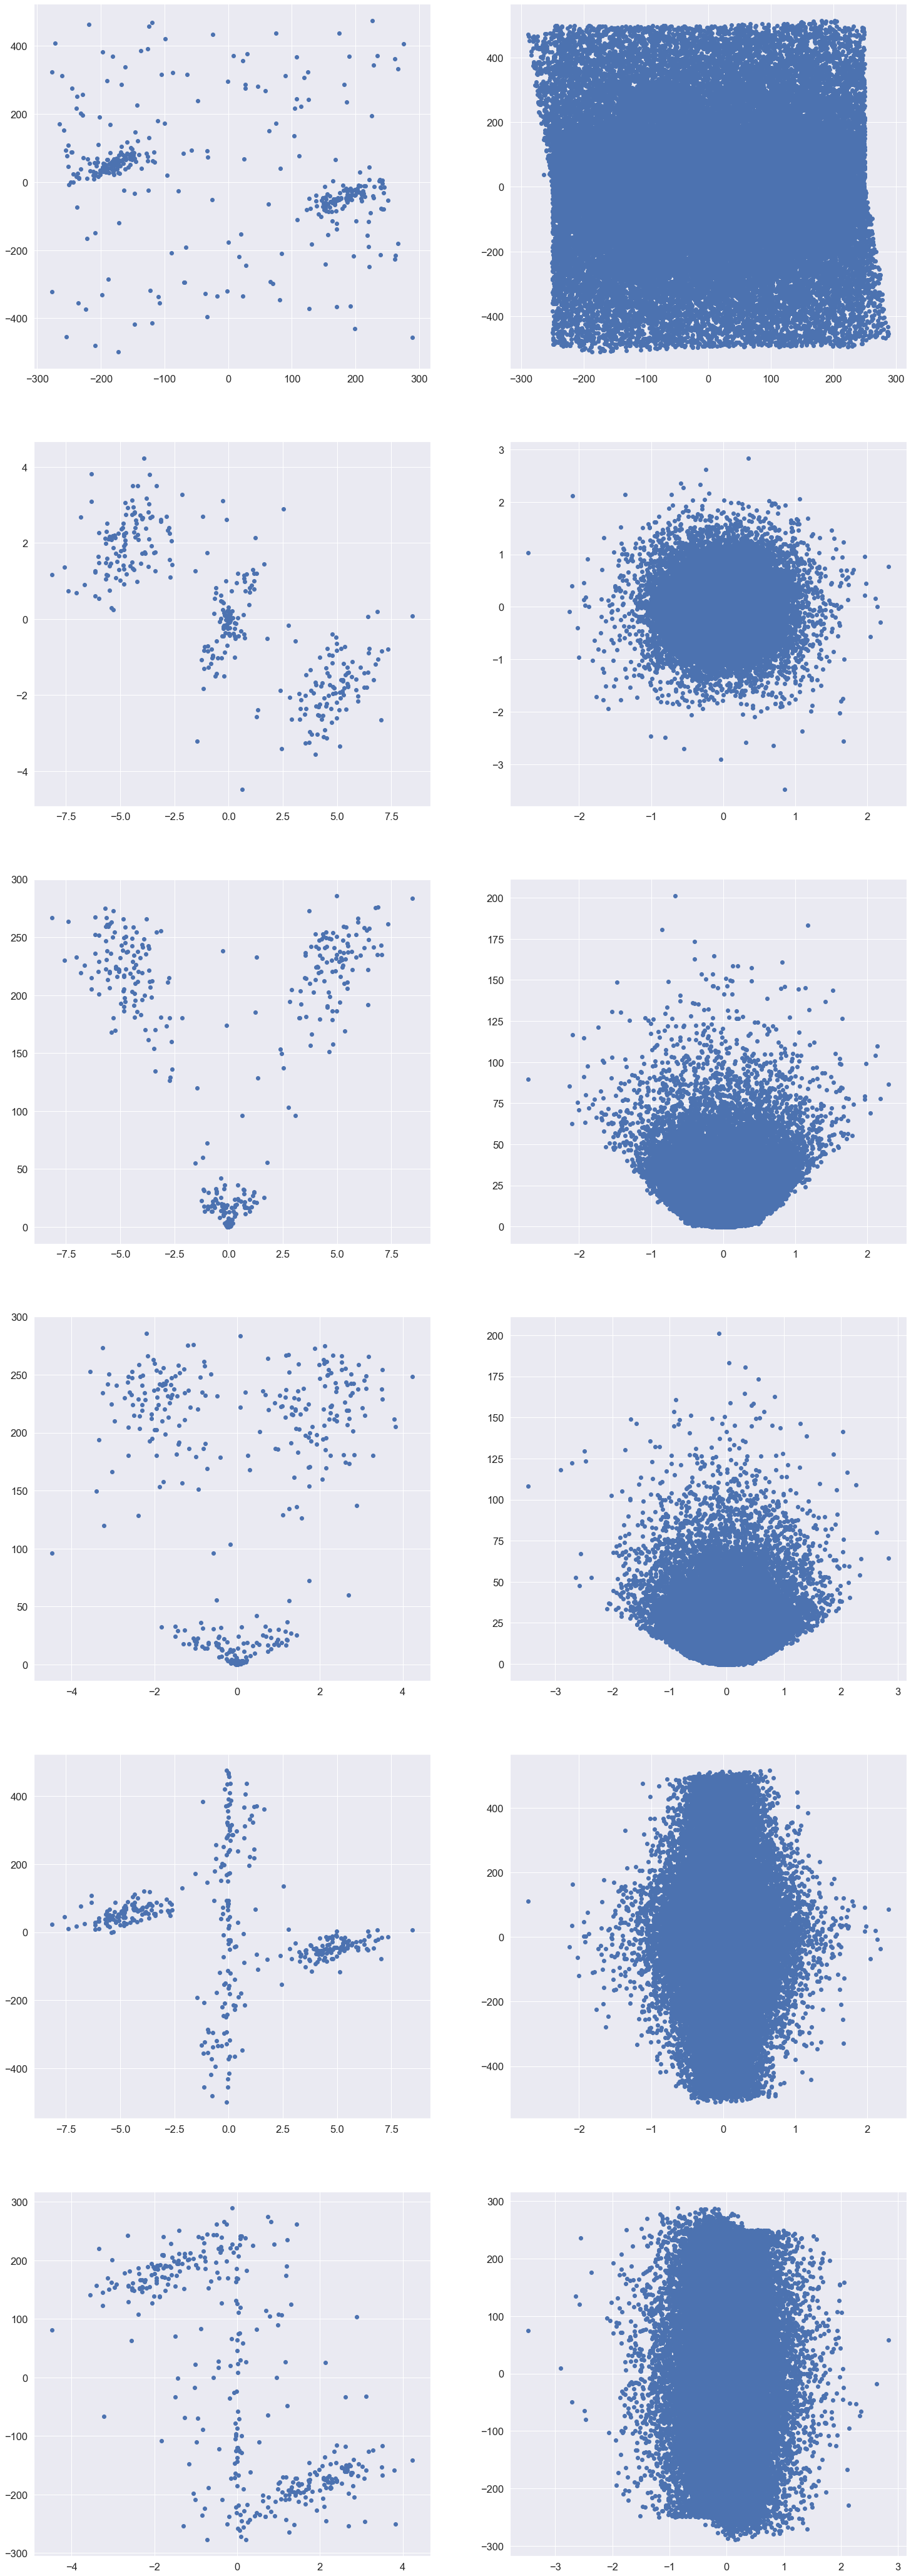

In [680]:
plt.figure(figsize=(25, 75))

plt.subplot(6, 2, 1)
plt.scatter(data_bkg['X'], data_bkg['Y'])

plt.subplot(6, 2, 2)
plt.scatter(data_sig['X'], data_sig['Y'])

plt.subplot(6, 2, 3)
plt.scatter(data_bkg['Px'], data_bkg['Py'])

plt.subplot(6, 2, 4)
plt.scatter(data_sig['Px'], data_sig['Py'])

plt.subplot(6, 2, 5)
plt.scatter(data_bkg['Px'], data_bkg['Pz'])

plt.subplot(6, 2, 6)
plt.scatter(data_sig['Px'], data_sig['Pz'])

plt.subplot(6, 2, 7)
plt.scatter(data_bkg['Py'], data_bkg['Pz'])

plt.subplot(6, 2, 8)
plt.scatter(data_sig['Py'], data_sig['Pz'])

plt.subplot(6, 2, 9)
plt.scatter(data_bkg['Px'], data_bkg['Y'])

plt.subplot(6, 2, 10)
plt.scatter(data_sig['Px'], data_sig['Y'])

plt.subplot(6, 2, 11)
plt.scatter(data_bkg['Py'], data_bkg['X'])

plt.subplot(6, 2, 12)
plt.scatter(data_sig['Py'], data_sig['X'])

plt.show()

In [681]:
def transform(x, y, bx=None, by=None):
    
    if not bx:
        bx = (x.max(), x.min())
    if not by:
        by = (y.max(), y.min())
    
    e = 2 * (x - (bx[0] + bx[1]) / 2) / (bx[0] - bx[1])
    n = 2 * (y - (by[0] + by[1]) / 2) / (by[0] - by[1])

    e1 = e * np.exp(1 / (np.abs(e) ** 2 + 0.3)) * (n + 1.01)
    n1 = n * np.exp(1 / (np.abs(n) ** 2 + 0.3))

    return e1, n1

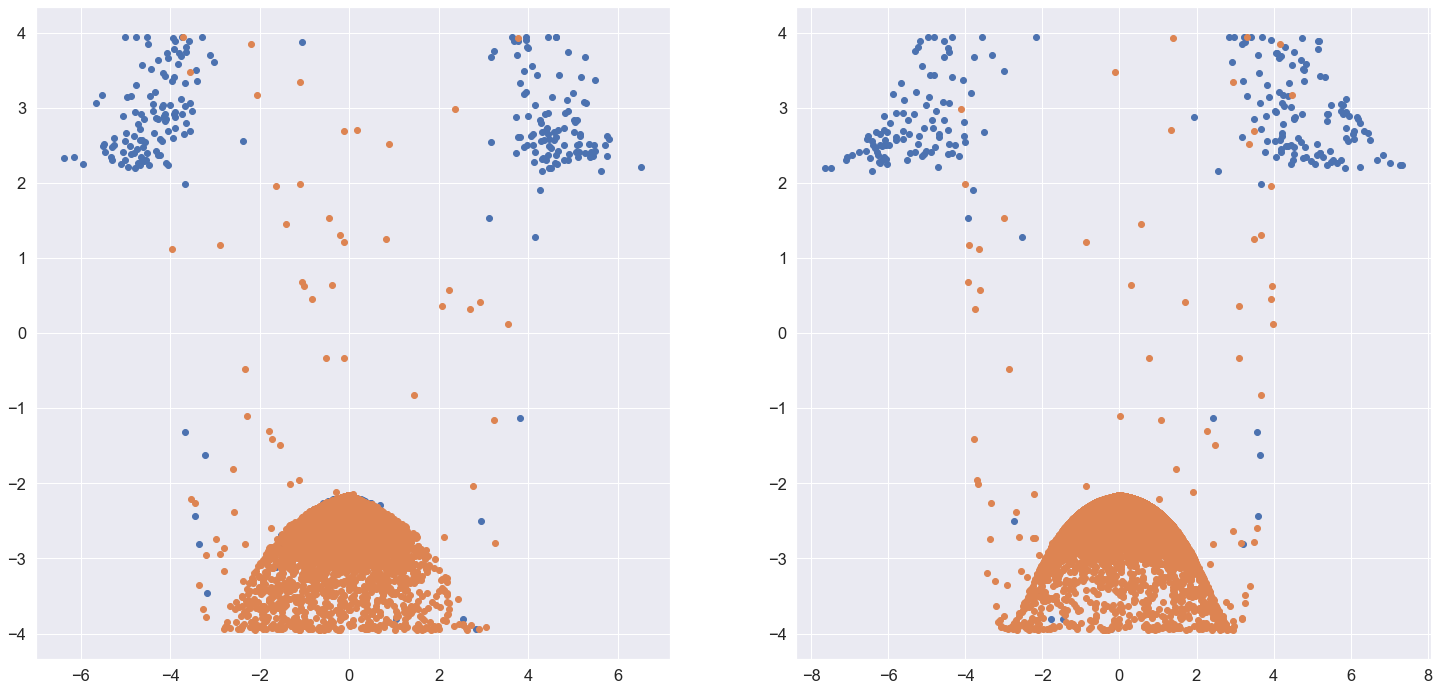

In [682]:
plt.figure(figsize=(25, 12))

plt.subplot(1, 2, 1)
bx = (X_bkg['Px'].max(), X_bkg['Px'].min())
by = (X_bkg['Pz'].max(), X_bkg['Pz'].min())
X_bkg['Px_tr'], X_bkg['Pz_tr'] = transform(X_bkg['Px'], X_bkg['Pz'], bx, by)
plt.scatter(X_bkg['Px_tr'], X_bkg['Pz_tr'])
plt.scatter(transform(X_sig['Px'], X_sig['Pz'], bx, by)[0], transform(X_sig['Px'], X_sig['Pz'], bx, by)[1])

plt.subplot(1, 2, 2)
bx = (X_bkg['Py'].max(), X_bkg['Py'].min())
by = (X_bkg['Pz'].max(), X_bkg['Pz'].min())
X_bkg['Py_tr'], X_bkg['Pz_tr'] = transform(X_bkg['Py'], X_bkg['Pz'], bx, by)
plt.scatter(X_bkg['Py_tr'], X_bkg['Pz_tr'])
plt.scatter(transform(X_sig['Py'], X_sig['Pz'], bx, by)[0], transform(X_sig['Py'], X_sig['Pz'], bx, by)[1])

plt.show()

In [683]:
X['Py_tr'], X['Pz_tr'] = transform(X['Py'], X['Pz'], (X['Py'].max(), X['Py'].min()), (X['Pz'].max(), X['Pz'].min()))
X['Px_tr'], X['Pz_tr1'] = transform(X['Px'], X['Pz'], (X['Px'].max(), X['Px'].min()), (X['Pz'].max(), X['Pz'].min()))

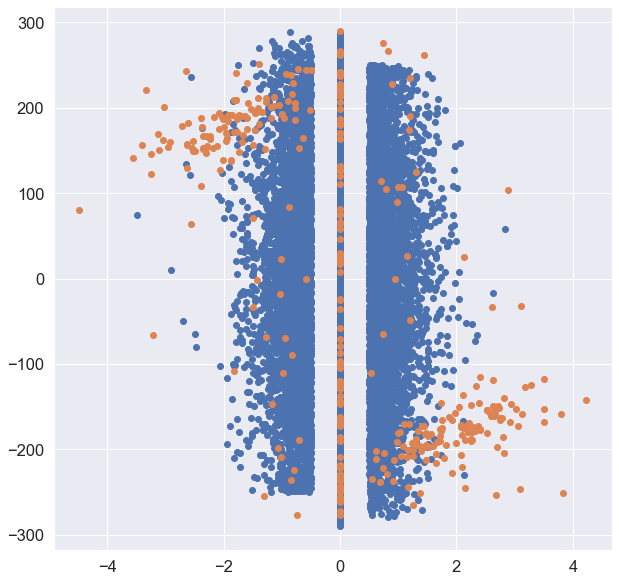

In [750]:
plt.figure(figsize=(10, 10))

plt.scatter(np.where(np.abs(X_sig['Py']) < 0.5, 0, X_sig['Py']), X_sig['X'])
plt.scatter(np.where(np.abs(X_bkg['Py']) < 0.5, 0, X_bkg['Py']), X_bkg['X'])

plt.show()

In [685]:
X['Px_tr1'] = np.where(np.abs(X['Px']) < 0.5, 0, X['Px'])
X['Py_tr1'] = np.where(np.abs(X['Py']) < 0.5, 0, X['Py'])

In [686]:
def best_params(X, y, N, r=7):

    result = np.empty((N, 2), dtype=object)

    num = 0

    for i in range(r, X.columns.size + 1):

        for cols in it.combinations(X.columns, i):

            result[num, 0] = get_metrics(X[list(cols)], y)['recall'].mean()
            result[num, 1] = cols
            num += 1
            if (num == N): break

        if (num == N): break

    return list(result[result[:, 0].argmax()][1])

In [687]:
best = best_params(X, y, 3000, 5)

In [689]:
get_metrics(X[best], y)

,method,recall,precision
0,log_reg,0.621320,0.915142
1,knn,0.627948,1.000000


In [690]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Попробавть выделить три кластера и отдельно их проклассифицировать

 преобразование которая позволяет раздвинуть кластеры

In [695]:
from sklearn.cluster import KMeans 

cluster = KMeans(n_clusters=3, algorithm='lloyd', max_iter=10000).fit(X_train[y_train == 1].drop(['T', 'Px', 'Py', 'Pz', 'X', 'Y'], axis=1))

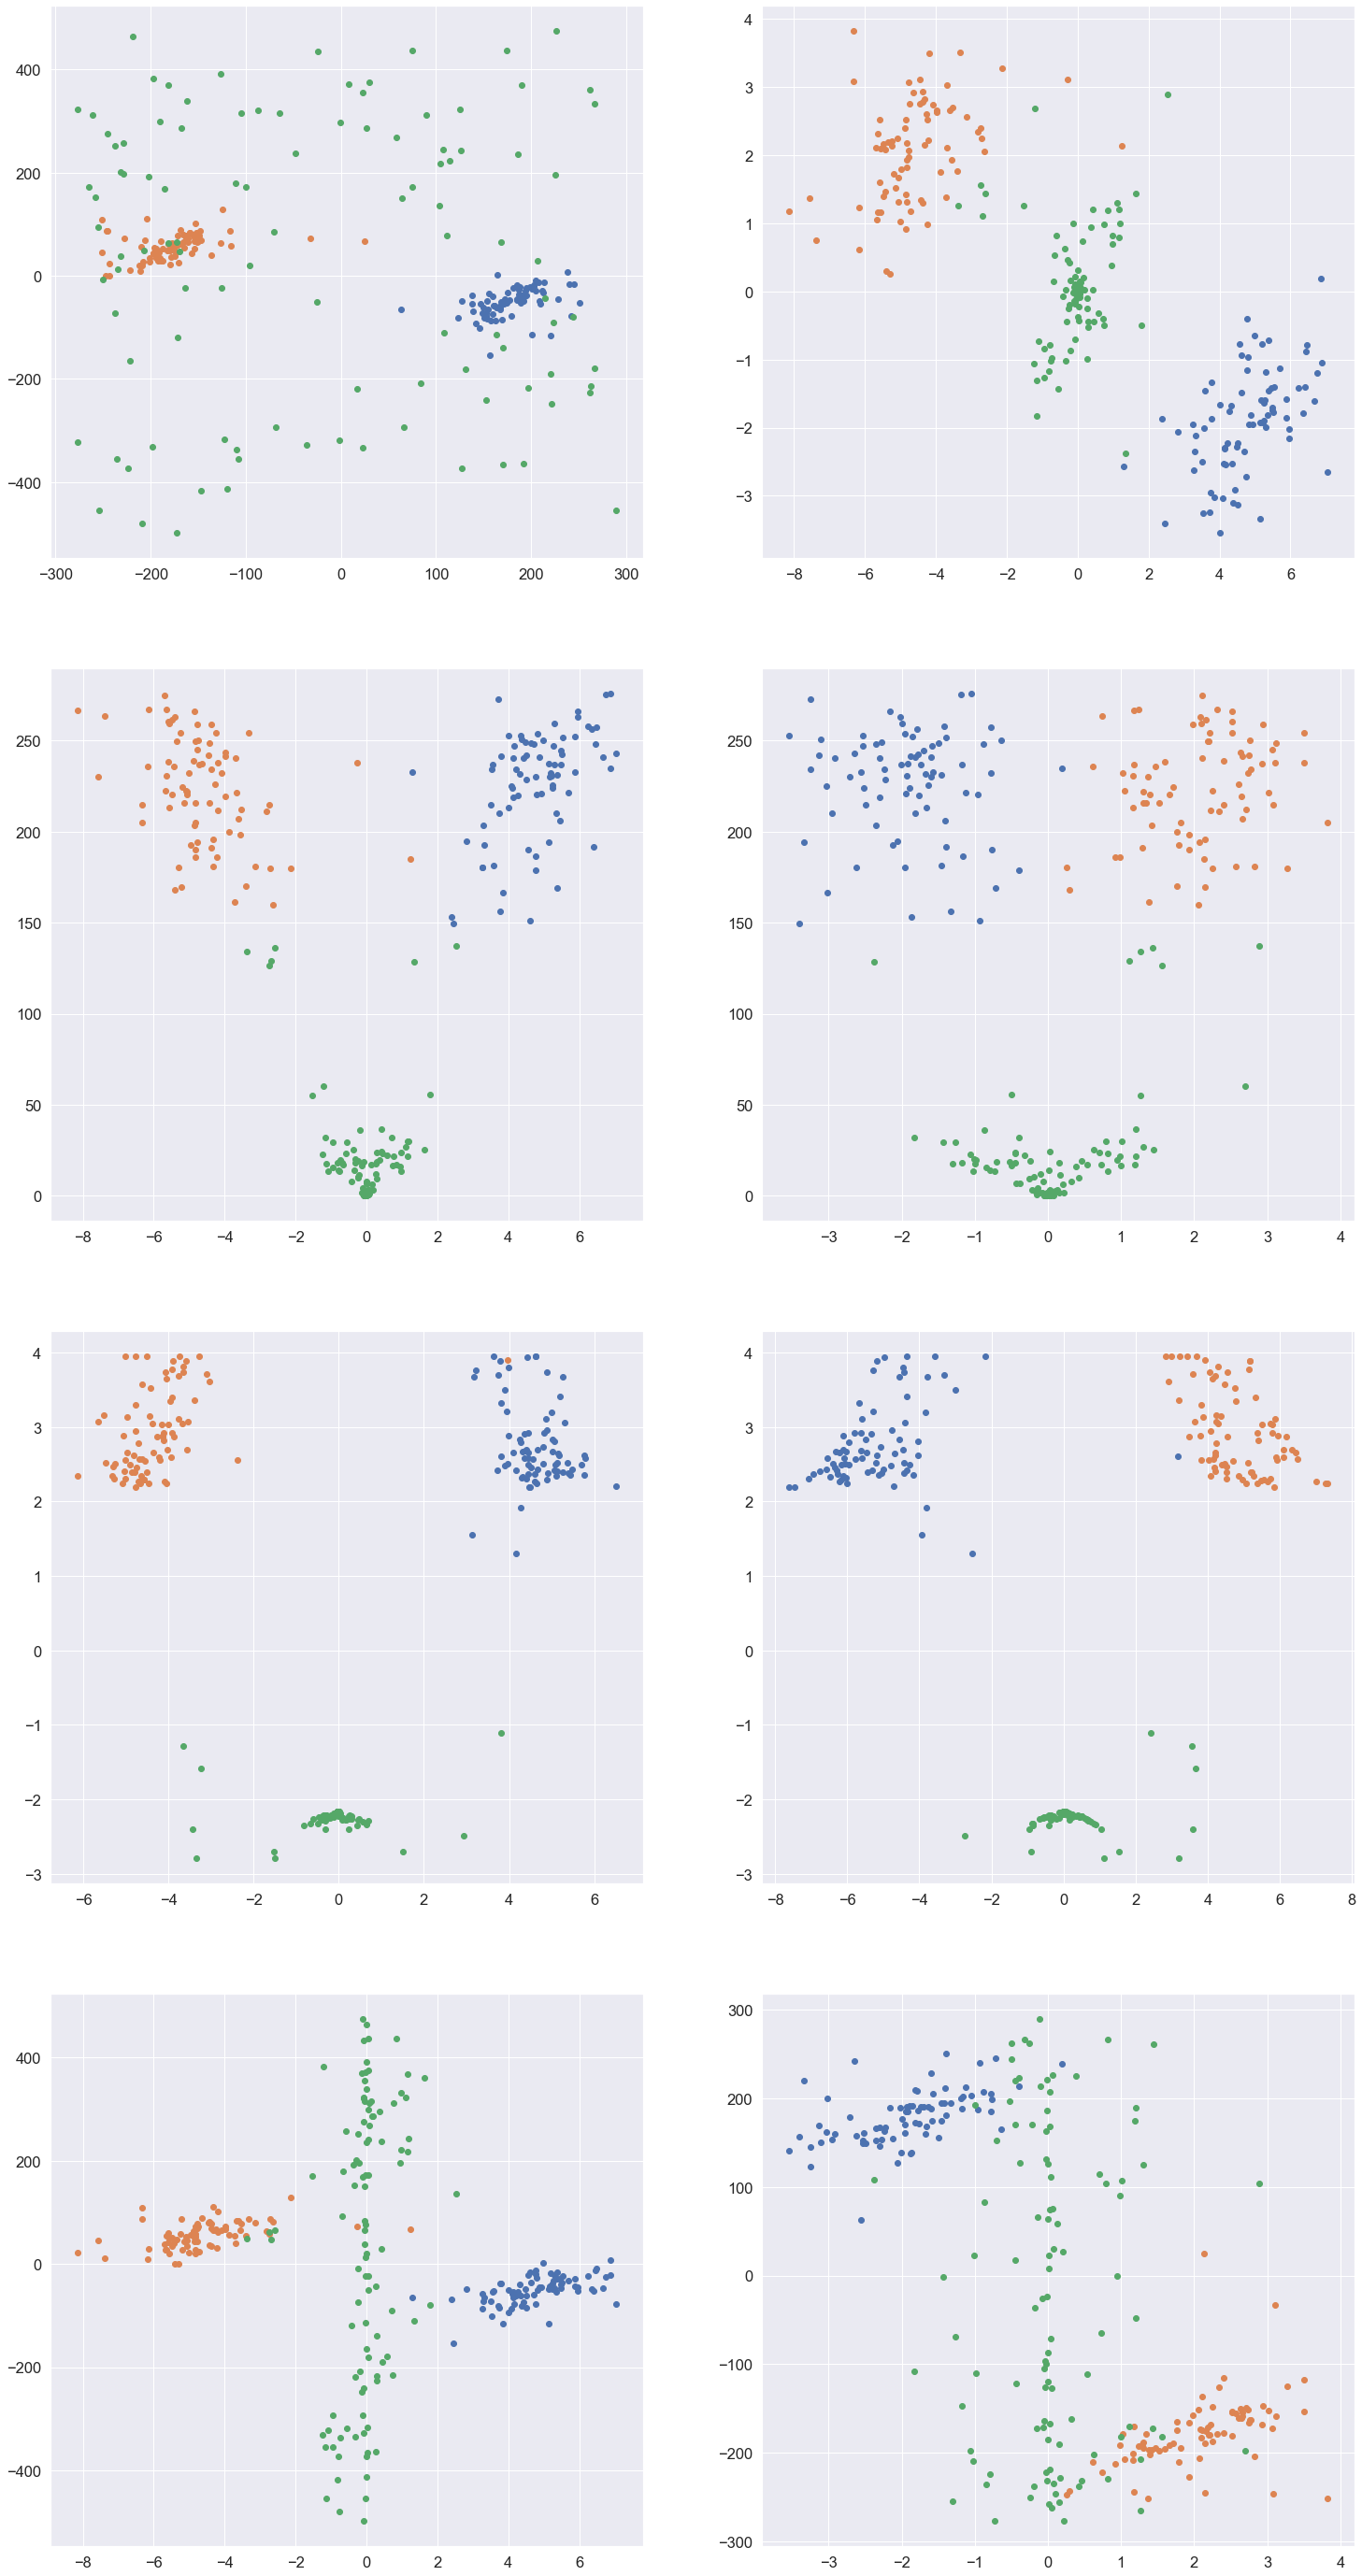

In [696]:
plt.figure(figsize=(25, 50))

plt.subplot(4, 2, 1)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['X'][cluster.labels_ == i], X_train[y_train == 1]['Y'][cluster.labels_ == i])

plt.subplot(4, 2, 2)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Py'][cluster.labels_ == i])

plt.subplot(4, 2, 3)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Pz'][cluster.labels_ == i])

plt.subplot(4, 2, 4)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py'][cluster.labels_ == i], X_train[y_train == 1]['Pz'][cluster.labels_ == i])

plt.subplot(4, 2, 5)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px_tr'][cluster.labels_ == i], X_train[y_train == 1]['Pz_tr'][cluster.labels_ == i])

plt.subplot(4, 2, 6)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py_tr'][cluster.labels_ == i], X_train[y_train == 1]['Pz_tr'][cluster.labels_ == i])

plt.subplot(4, 2, 7)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Y'][cluster.labels_ == i])

plt.subplot(4, 2, 8)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py'][cluster.labels_ == i], X_train[y_train == 1]['X'][cluster.labels_ == i])

plt.show()

In [697]:
X1_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 0])
y1_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 0])

X2_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 1])
y2_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 1])

X3_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 2])
y3_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 2])

In [698]:
clust_pred = cluster.predict(X_test.drop(['T', 'Px', 'Py', 'Pz', 'X', 'Y'], axis=1))

X1_test = X_test[clust_pred == 0]
y1_test = y_test[clust_pred == 0]
X1 = X1_train.append(X1_test)
y1 = y1_train.append(y1_test)

X2_test = X_test[clust_pred == 1]
y2_test = y_test[clust_pred == 1]
X2 = X2_train.append(X2_test)
y2 = y2_train.append(y2_test)

X3_test = X_test[clust_pred == 2]
y3_test = y_test[clust_pred == 2]
X3 = X3_train.append(X3_test)
y3 = y3_train.append(y3_test)

In [702]:
get_metrics(X1, y1)

,method,recall,precision
0,log_reg,0.989583,0.983744
1,knn,0.944081,0.973810


In [703]:
best1 = best_params(X1, y1, 3000, 5)

In [704]:
get_metrics(X1[best1], y1)

,method,recall,precision
0,log_reg,1.0,0.994048
1,knn,1.0,1.000000


In [705]:
get_metrics(X2, y2)

,method,recall,precision
0,log_reg,0.963758,0.990406
1,knn,0.971676,0.980218


In [706]:
best2 = best_params(X2, y2, 3000, 5)

In [707]:
get_metrics(X2[best2], y2)

,method,recall,precision
0,log_reg,1.000000,0.981989
1,knn,0.971676,0.980218


In [708]:
get_metrics(X3, y3)

,method,recall,precision
0,log_reg,0.0,0.0
1,knn,0.0,0.0


In [709]:
def cluster_metrics(X, y, states=[0, 6, 7, 13, 42, 911], size=0.3):

    log_reg_rec = []
    knn_rec = []

    log_reg_prs = []
    knn_prs = []

    for state in states:

        TP_log_reg = np.empty(len(X))
        FP_log_reg = np.empty(len(X))
        TN_log_reg = np.empty(len(X))
        FN_log_reg = np.empty(len(X))

        TP_knn = np.empty(len(X))
        FP_knn = np.empty(len(X))
        TN_knn = np.empty(len(X))
        FN_knn = np.empty(len(X))

        for i in range(len(X)):

            X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], random_state=state, test_size=size)

            log_reg = LogisticRegression().fit(X_train, y_train).predict(X_test)
            knn = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)

            TP_log_reg[i] = (log_reg * y_test).sum()
            FN_log_reg[i] = ((np.ones_like(log_reg) - log_reg) * y_test).sum()
            TN_log_reg[i] = ((np.ones_like(log_reg) - log_reg) * (np.ones_like(y_test) - y_test)).sum()
            FP_log_reg[i] = (log_reg * (np.ones_like(y_test) - y_test)).sum()

            TP_knn[i] = (knn * y_test).sum()
            FN_knn[i] = ((np.ones_like(knn) - knn) * y_test).sum()
            TN_knn[i] = ((np.ones_like(knn) - knn) * (np.ones_like(y_test) - y_test)).sum()
            FP_knn[i] = (knn * (np.ones_like(y_test) - y_test)).sum()

        log_reg_rec.append(TP_log_reg.sum() / (TP_log_reg.sum() + FN_log_reg.sum()))
        knn_rec.append(TP_knn.sum() / (TP_knn.sum() + FN_knn.sum()))

        log_reg_prs.append(TP_log_reg.sum() / (TP_log_reg.sum() + FP_log_reg.sum()))
        knn_prs.append(TP_knn.sum() / (TP_knn.sum() + FP_knn.sum()))

    return pd.DataFrame({'method': ['log_reg', 'knn'], 
                         'recall': [np.mean(log_reg_rec), np.mean(knn_rec)],
                         'precision': [np.mean(log_reg_prs), np.mean(knn_prs)]})

In [710]:
cluster_metrics([X1[best1], X2[best2], X3], [y1, y2, y3])

,method,recall,precision
0,log_reg,0.596637,0.969744
1,knn,0.586919,0.989408


Чекать по прямой средний кластер в плоскости Px Py, Px Y, Py, X

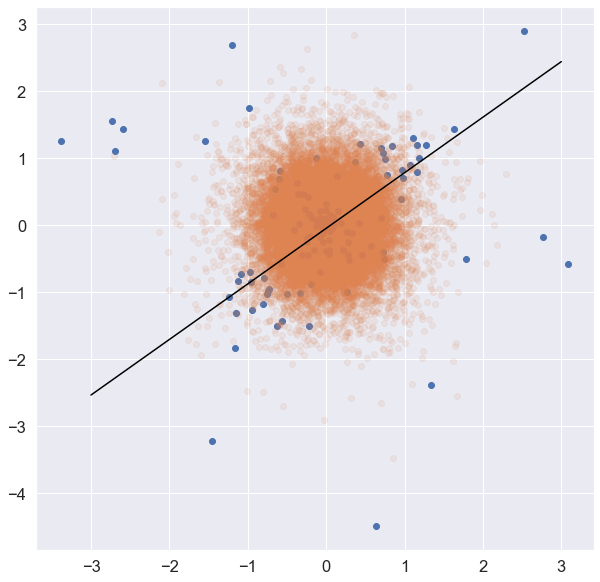

In [711]:
plt.figure(figsize=(10, 10))
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Py'], alpha=1)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Py'], alpha=0.1)

k, b = np.polyfit(X3[y3 == 1]['Px'][(np.abs(X3['Px'][y3 == 1]) < 1.2) * (np.abs(X3['Px'][y3 == 1]) > 0.7)], X3[y3 == 1]['Py'][(np.abs(X3['Px'][y3 == 1]) < 1.2) * (np.abs(X3['Px'][y3 == 1]) > 0.7)], deg=1)

x = np.linspace(-3, 3, 2)

plt.plot(x, k * x + b, 'black')

plt.show()

In [712]:
X3['centr_dist'] = X3['Px'] ** 2 + X3['Py'] ** 2
X3['line_dist'] = np.abs((X3['Py'] -  (k * X3['Px'] + b)) / (k ** 2 + 1) ** 0.5)

In [713]:
get_metrics(X3, y3)

,method,recall,precision
0,log_reg,0.055764,0.515873
1,knn,0.000000,0.000000


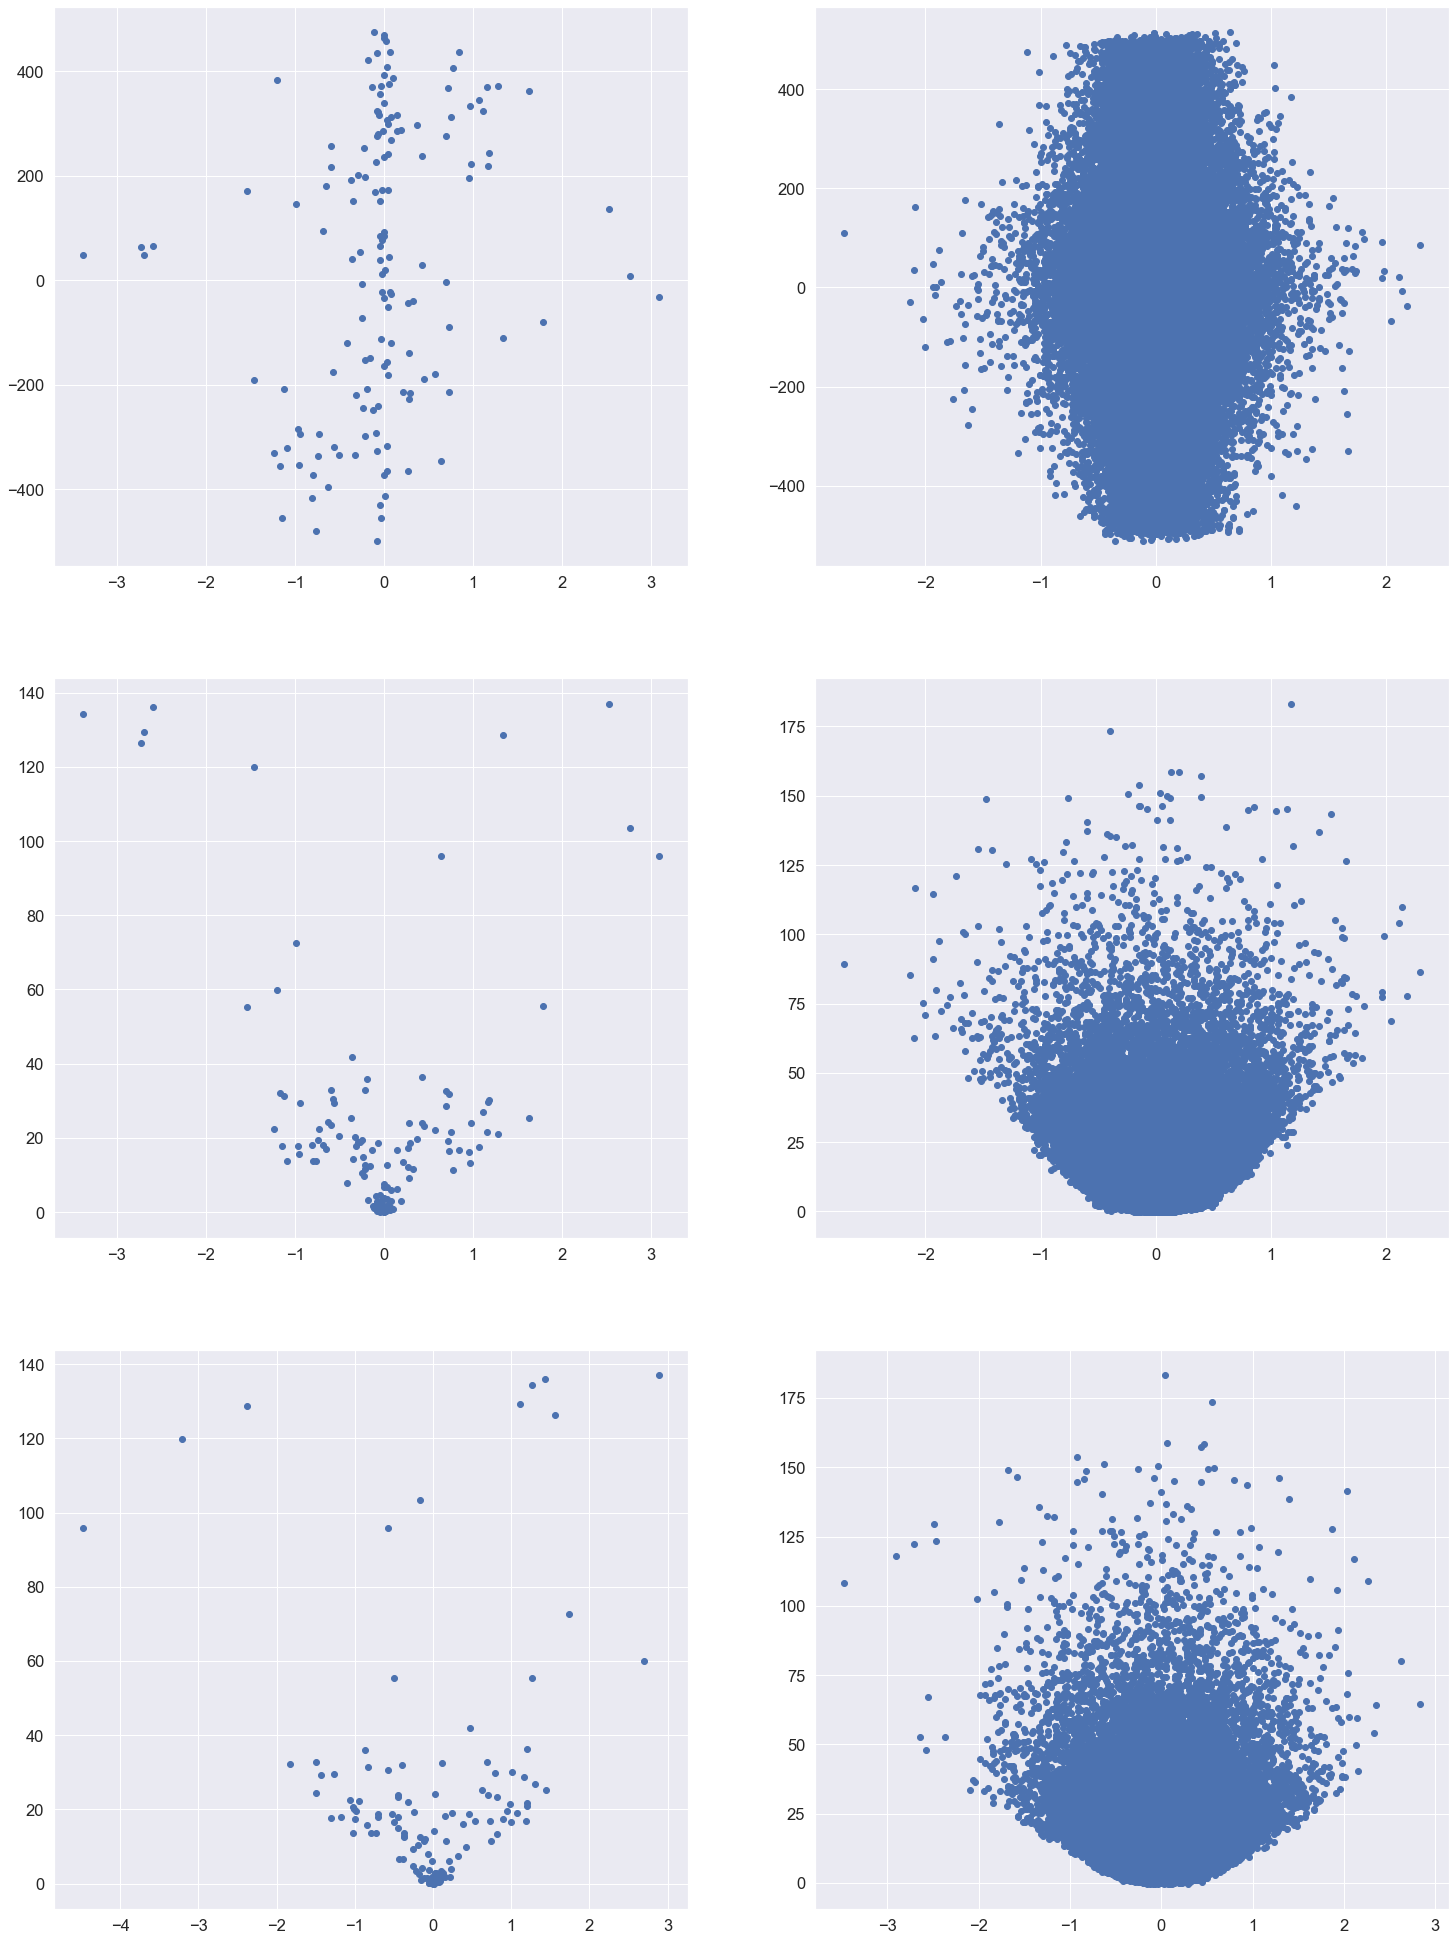

In [714]:
plt.figure(figsize=(25, 35))

plt.subplot(3, 2, 1)
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Y'])

plt.subplot(3, 2, 2)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Y'])

plt.subplot(3, 2, 3)
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Pz'])

plt.subplot(3, 2, 4)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Pz'])

plt.subplot(3, 2, 5)
plt.scatter(X3[y3 == 1]['Py'], X3[y3 == 1]['Pz'])

plt.subplot(3, 2, 6)
plt.scatter(X3[y3 == 0]['Py'], X3[y3 == 0]['Pz'])

plt.show()

In [715]:
X3['PyPz_div'] = np.where((X3['Pz'] < 40) * (X3['Pz'] > -20 * X3['Py'] - 10) * (X3['Pz'] > 20 * X3['Py'] - 10), 1, 0)
X3['PxPz_div'] = np.where((X3['Pz'] < 40) * (X3['Pz'] > -20 * X3['Px'] - 10) * (X3['Pz'] > 20 * X3['Px'] - 10), 1, 0)
X3['PxY_div'] = np.where(np.abs(X3['Px']) <  0.7, 1, 0)

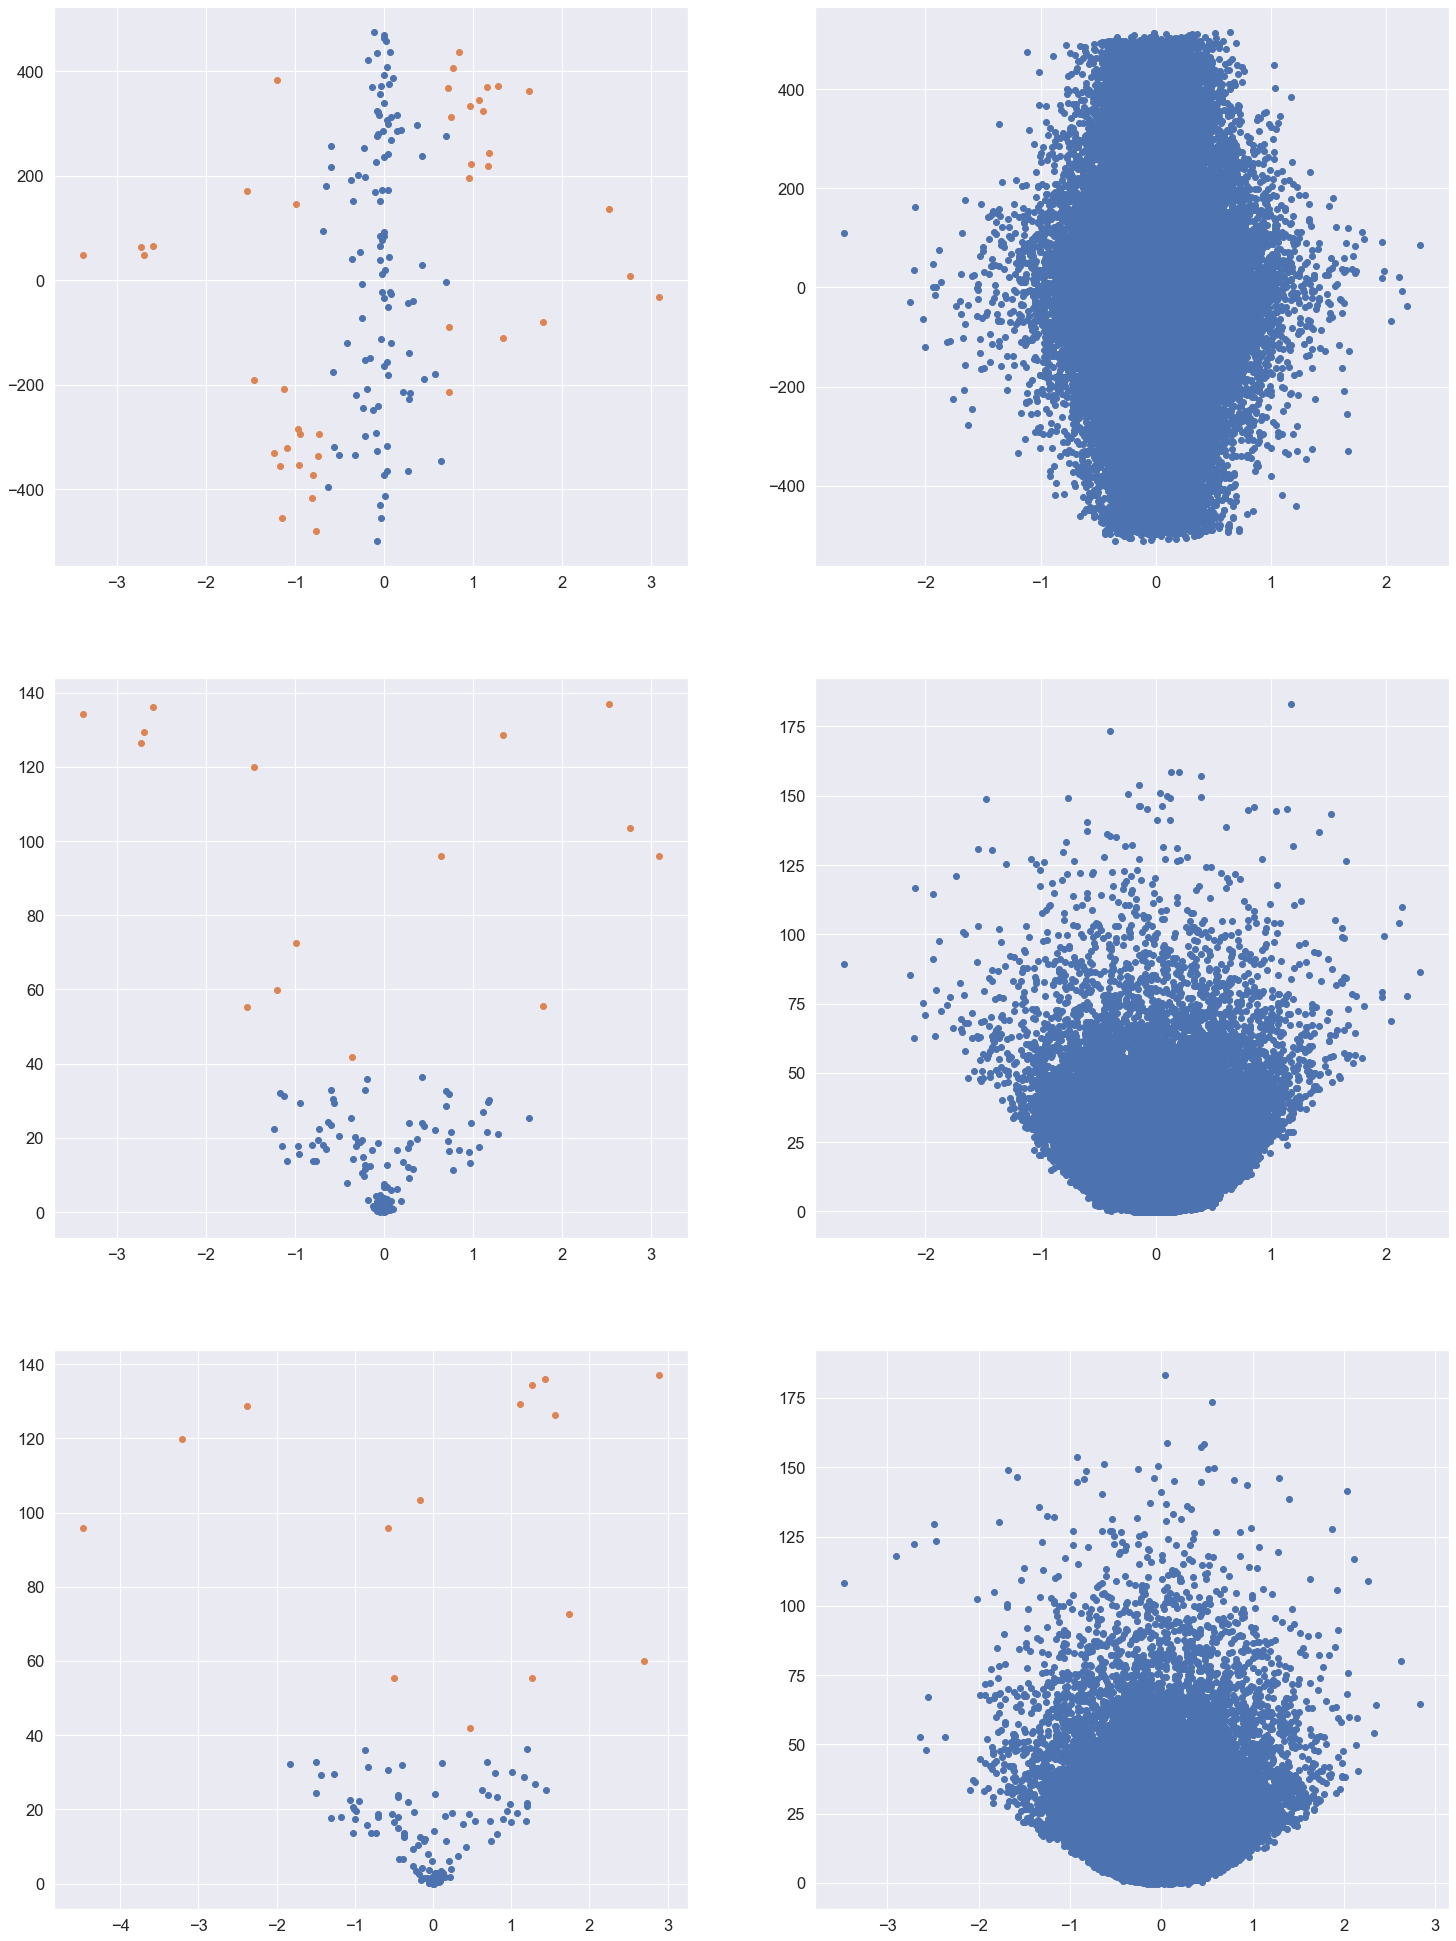

In [716]:
plt.figure(figsize=(25, 35))

plt.subplot(3, 2, 1)
plt.scatter(X3[(y3 == 1) * (X3['PxY_div'] == 1)]['Px'], X3[(y3 == 1) * (X3['PxY_div'] == 1)]['Y'])
plt.scatter(X3[(y3 == 1) * (X3['PxY_div'] == 0)]['Px'], X3[(y3 == 1) * (X3['PxY_div'] == 0)]['Y'])

plt.subplot(3, 2, 2)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Y'])

plt.subplot(3, 2, 3)
plt.scatter(X3[(y3 == 1) * (X3['PxPz_div'] == 1)]['Px'], X3[(y3 == 1) * (X3['PxPz_div'] == 1)]['Pz'])
plt.scatter(X3[(y3 == 1) * (X3['PxPz_div'] == 0)]['Px'], X3[(y3 == 1) * (X3['PxPz_div'] == 0)]['Pz'])

plt.subplot(3, 2, 4)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Pz'])

plt.subplot(3, 2, 5)
plt.scatter(X3[(y3 == 1) * (X3['PyPz_div'] == 1)]['Py'], X3[(y3 == 1) * (X3['PyPz_div'] == 1)]['Pz'])
plt.scatter(X3[(y3 == 1) * (X3['PyPz_div'] == 0)]['Py'], X3[(y3 == 1) * (X3['PyPz_div'] == 0)]['Pz'])

plt.subplot(3, 2, 6)
plt.scatter(X3[y3 == 0]['Py'], X3[y3 == 0]['Pz'])

plt.show()

In [717]:
get_metrics(X3, y3)

,method,recall,precision
0,log_reg,0.057054,0.552778
1,knn,0.000000,0.000000


In [718]:
cluster_metrics([X1[best1], X2[best2], X3], [y1, y2, y3])

,method,recall,precision
0,log_reg,0.619731,0.957239
1,knn,0.586919,0.989408


In [719]:
best3 = best_params(X3, y3, 3000)

In [720]:
get_metrics(X3[best3], y3)

,method,recall,precision
0,log_reg,0.067874,0.601852
1,knn,0.004762,0.166667


In [721]:
cluster_metrics([X1[best1], X2[best2], X3[best3]], [y1, y2, y3])

,method,recall,precision
0,log_reg,0.624214,0.949606
1,knn,0.588602,0.989450


>## CatBoost

In [722]:
from catboost import CatBoostClassifier

In [723]:
rec1 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)

    y1_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec1.append(recall_score(y1_test, y1_pred))

rec1 = np.mean(rec1)

print(rec1)

0.98371686637618


In [724]:
rec2 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)

    y2_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec2.append(recall_score(y2_test, y2_pred))

rec2 = np.mean(rec2)

print(rec2)

0.9895731508634734


In [725]:
rec = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec.append(recall_score(y3_test, y3_pred))

rec3 = np.mean(rec)

print(rec3)

0.07142274702772729


In [726]:
rec = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)
    y1_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)

    X_train, X_test, y_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)
    y2_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)

    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)
    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(X_train, y_train).predict(X_test)

    y_pred = np.hstack((y1_pred, np.hstack((y2_pred, y3_pred))))
    y_test = np.hstack((y1_test, np.hstack((y2_test, y3_test))))
    
    rec.append(recall_score(y_test, y_pred))

rec = np.mean(rec)

print(rec)

0.6181825205592734


Нагенерить SMOTE частиц каждого класса
Обучить регрессию на каждом классе по отдельности

>## Over-Sampling при помощи SMOTE

In [727]:
from imblearn.over_sampling import SMOTE

In [728]:
def get_metrics(X_train, X_test, y_train, y_test):

    log_reg_os = LogisticRegression(max_iter=100000).fit(X_train, y_train).predict(X_test)
    knn_os = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)

    return pd.DataFrame({'method': ['log_reg', 'knn'],
                         'recall': [recall_score(log_reg_os, y_test), recall_score(knn_os, y_test)],
                         'precision': [precision_score(log_reg_os, y_test), precision_score(knn_os, y_test)]})

In [729]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3)

In [730]:
os = SMOTE(random_state=42)

columns = X1_train.columns

os_data_X1, os_data_y1 = os.fit_resample(X1_train, y1_train)

os_data_X1 = pd.DataFrame(data=os_data_X1, columns=columns)

In [731]:
get_metrics(os_data_X1, X1_test, os_data_y1, y1_test)

,method,recall,precision
0,log_reg,1.0,1.0
1,knn,1.0,1.0


In [732]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3)

In [733]:
os = SMOTE(random_state=42)

columns = X2_train.columns

os_data_X2, os_data_y2 = os.fit_resample(X2_train, y2_train)

os_data_X2 = pd.DataFrame(data=os_data_X2, columns=columns)

In [734]:
get_metrics(os_data_X2, X2_test, os_data_y2, y2_test)

,method,recall,precision
0,log_reg,0.780488,1.0
1,knn,0.864865,1.0


In [735]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

In [736]:
os = SMOTE(random_state=42)

columns = X3_train.columns

os_data_X3, os_data_y3 = os.fit_resample(X3_train, y3_train)

os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

In [737]:
get_metrics(os_data_X3, X3_test, os_data_y3, y3_test)

,method,recall,precision
0,log_reg,0.008328,0.608696
1,knn,0.006088,0.173913


In [749]:
rec3 = []
prs3 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    os = SMOTE(random_state=i)

    columns = X_train.columns

    os_data_X3, os_data_y3 = os.fit_resample(X_train, y_train)

    os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(os_data_X3, os_data_y3).predict(X_test)
    
    rec3.append(recall_score(y3_test, y3_pred))
    prs3.append(precision_score(y3_test, y3_pred))

rec3 = np.mean(rec3)
prs3 = np.mean(prs3)

print('Recall score: {}'.format(rec3))
print('Precision score: {}'.format(prs3))

Recall score: 0.27872074740383207
Precision score: 0.08351639211473015


In [747]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X1_train.columns

    os_data_X1, os_data_y1 = os.fit_resample(X1_train, y1_train)

    os_data_X1 = pd.DataFrame(data=os_data_X1, columns=columns)

    y1_pred = ((LogisticRegression(max_iter=100000).fit(os_data_X1, os_data_y1).predict(X1_test) + KNeighborsClassifier().fit(os_data_X1, os_data_y1).predict(X1_test)) > 0)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X2_train.columns

    os_data_X2, os_data_y2 = os.fit_resample(X2_train, y2_train)

    os_data_X2 = pd.DataFrame(data=os_data_X2, columns=columns)

    y2_pred = ((LogisticRegression(max_iter=100000).fit(os_data_X2, os_data_y2).predict(X2_test) + KNeighborsClassifier().fit(os_data_X2, os_data_y2).predict(X2_test)) > 0)
    
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X3_train.columns

    os_data_X3, os_data_y3 = os.fit_resample(X3_train, y3_train)

    os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(os_data_X3, os_data_y3).predict(X3_test)
    
    y_pred = np.hstack((y1_pred, np.hstack((y2_pred, y3_pred))))
    y_test = np.hstack((y1_test, np.hstack((y2_test, y3_test))))
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.7099285370341019
Precision score: 0.35708008400114194
